In [1]:
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pickle

import math
import cv2
import numpy as np
from numpy import cos as cos
from numpy import sin as sin
from numpy import sqrt as sqrt
from numpy import arctan2 as arctan2
import os
import datetime
import time

import sys
from functions import *
from tf_functions import *
from zernike_functions import *

In [3]:
def init_param():
    ### N: pix num, p: pix size[m]
    N = 2160
    p = 3.74e-6

    ### l_ambda: wavelength
    l_ambda = 520e-9

    ### z: distance from aperture to screen
    z = 0.04

    ### pupil_r: pupil radius, pupil_r_m: (m)
    pupil_r_m = N*p/2
    pupil_r_mm = pupil_r_m*1000

    ### focus length of lens
    lens_f = 0.02

    ##### Zernike Efficients Setting #####
    nm_arr = [[2,0], [3,1]]
    nm_coeff_arr = [1.0, 1.0]

    return N, z, p, l_ambda, pupil_r_m, pupil_r_mm, lens_f, nm_arr, nm_coeff_arr

In [4]:
# gpu_id = 0
# print(tf.__version__)
# if tf.__version__ >= "2.1.0":
#     physical_devices = tf.config.list_physical_devices('GPU')
#     tf.config.list_physical_devices('GPU')
#     tf.config.set_visible_devices(physical_devices[gpu_id], 'GPU')
#     tf.config.experimental.set_memory_growth(physical_devices[gpu_id], True)
#     print('set gpu_id')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


False
0.05810233846153847
743.5156853212845
max:  223
max:  0.8745098039215686
inten min, max:  0.9999999999999998 1.0000000000000002
amp min, max:  0.9999999999999999 1.0


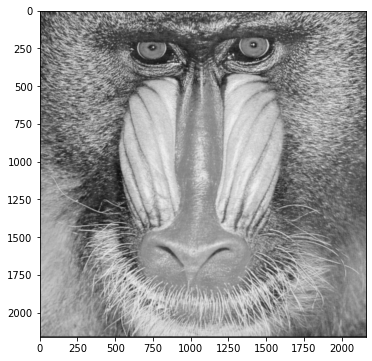

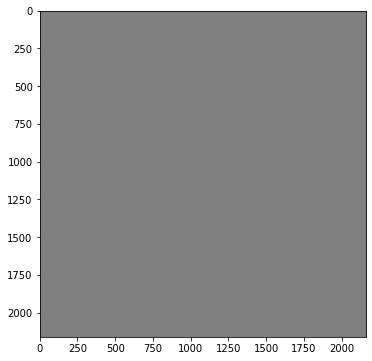

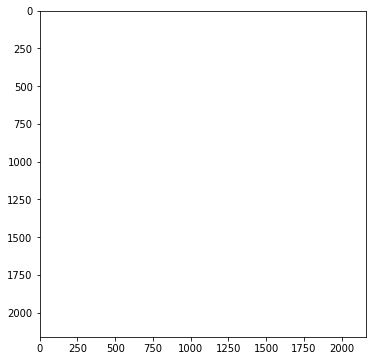

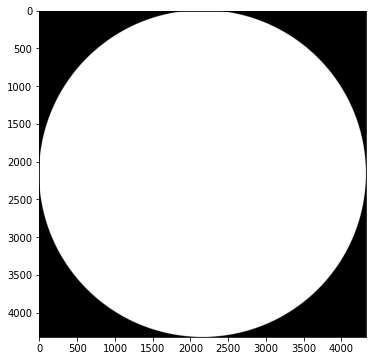

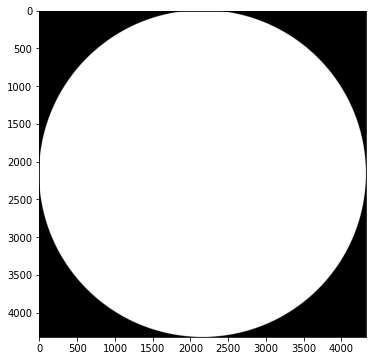

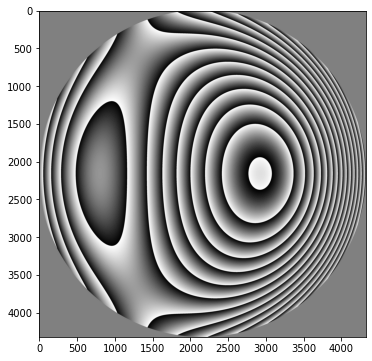

In [5]:
##### Initialization #####
### Initial Params
N, z, p, l_ambda, pupil_r_m, pupil_r_mm, lens_f, nm_arr, nm_coeff_arr = init_param()
back_z = z * -1.0
k = 2*np.pi/l_ambda

### lens override
o_lens_N = 2*N
pupil_r_m = 2*pupil_r_m

### Pupil Function(ふつうの)
p_xy = CGH.pupil_func(o_lens_N, p, pupil_r_m)
# p_xy = CGH.big_pupil_func(N)

### Wavefront Aberration
W_xy = np.zeros((o_lens_N, o_lens_N,))

for i in range(len(nm_arr)):
    nm = nm_arr[i]
    nm_coeff = nm_coeff_arr[i]
    temp_W_xy = CGH.norm_wave_aberration(o_lens_N, nm)
    temp_W_xy = CGH.resize_and_add_pad(temp_W_xy, o_lens_N, p, pupil_r_m)
    W_xy += temp_W_xy * nm_coeff

# W_xy = W_xy * 0.5
# W_xy = W_xy * 2.0

### Reverse Wavefront Aberration
rev_W_xy = W_xy * -1.0

### Generalized Pupil Function
P_xy = CGH.general_pupil(p_xy, W_xy, l_ambda)
rev_P_xy = CGH.general_pupil(p_xy, rev_W_xy, l_ambda)

###

### Directory and Path for Save
dir_fn = ''
fn = ''
out_path = PreProcess.mkdir_out_dir(dir_fn, fn, N, p, z)


##### Check Aliasing #####
CGH.check_aliasing(lens_f, N, l_ambda, p, z)


##### Input Image #####
in_dir = '../input/'
#in_dir = 'drive/My Drive/Colab Notebooks/input/'
amp_img_np = cv2.imread(in_dir + 'baboon_gray.png', cv2.IMREAD_GRAYSCALE)
# amp_img_np = cv2.imread(in_dir + 'peppers_gray.png', cv2.IMREAD_GRAYSCALE)
#amp_img_np = cv2.imread(in_dir + 'USAF_1951.png', cv2.IMREAD_GRAYSCALE)
#amp_img_np = cv2.imread(in_dir + 'white2160.png', cv2.IMREAD_GRAYSCALE)
size = (N, N)
half_size =(N//2, N//2)
amp_img_np = cv2.resize(amp_img_np, size)
print("max: ",amp_img_np.max())
#amp_img_np = cv2.resize(amp_img_np, half_size)
#amp_img_np = ImageProcess.add_zero_padding(amp_img_np)
amp_img_np = amp_img_np / 255.0
amp_img = tf.constant(amp_img_np)
amp_img = tf.dtypes.cast(amp_img, tf.float64)
print("max: ",amp_img_np.max())
cv2.imwrite('../output/check.png', amp_img_np)

##### Initial Random Phase #####
# phase = np.random.uniform(-np.pi, np.pi, size)
random_phase = np.random.uniform(0.0, 2.0*np.pi, size)
init_phase = tf.constant(random_phase)
phase = tf.Variable(random_phase)



##### Incident Light toward SLM #####
light_img = tf.fill(size, 1.0)
light_img = tf.dtypes.cast(light_img, tf.complex128)

###デバッグ用

# phase: なんでもあり(定義域がない)の値, phase_exp: 複素振幅の形に, np.exp(phase)
phase_exp = tf.dtypes.complex(tf.math.cos(phase), tf.math.sin(phase))
# Input Complex Amplitude: SLMに光があたった状態（light_img: amplitude, A exp(iφ), exp(iφ): phase_exp）
init_plane = tf.math.multiply(light_img, phase_exp)
init_plane_inten = CGH.intensity(init_plane.numpy())
init_plane_amp = CGH.amplitude(init_plane.numpy())
print("inten min, max: ",init_plane_inten.min(), init_plane_inten.max())
print("amp min, max: ",init_plane_amp.min(), init_plane_amp.max())

##### Target Image #####
source_amp = np.sqrt(amp_img)
source_img = source_amp

# When using Intensity Distribution
goal_img = amp_img
goal_img_tf = tf.constant(goal_img)
goal_img_tf = tf.dtypes.cast(goal_img_tf, tf.complex128)

target = amp_img

abe_imgs = [
    amp_img_np,
    CGH.amp_abs(CGH.intensity(init_plane.numpy())),
    CGH.amp_abs(CGH.amplitude(init_plane.numpy())),
    CGH.amp_abs(CGH.intensity(P_xy)),
    CGH.amp_abs(CGH.amplitude(P_xy)),
    CGH.phase_norm(CGH.phase(P_xy)),]
ImageProcess.show_imgs(abe_imgs)

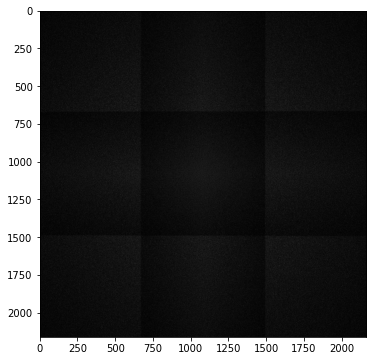

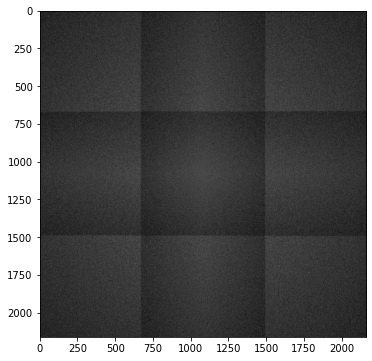

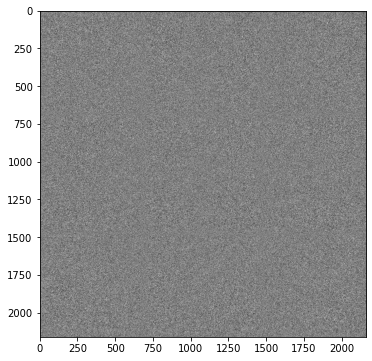

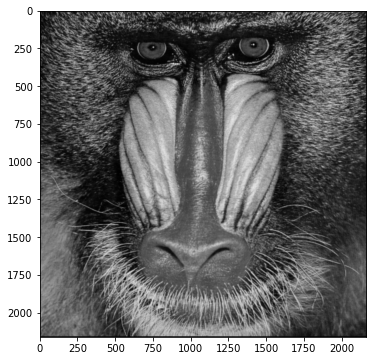

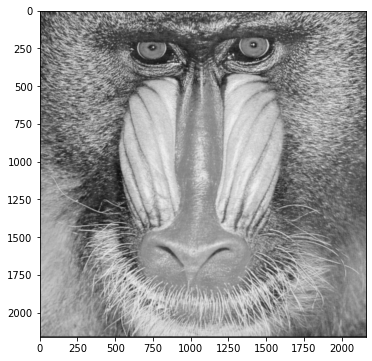

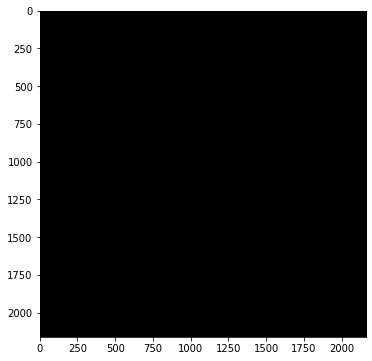

PSNR:  6.586709043726506
tf.Tensor(0.10972336041905743, shape=(), dtype=float64)


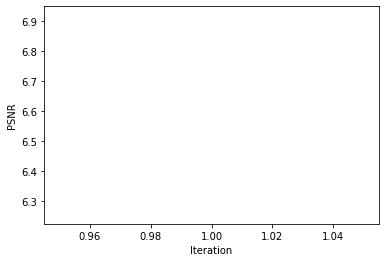

1
PSNR:  6.858156690284693
tf.Tensor(0.10307523540115246, shape=(), dtype=float64)
2


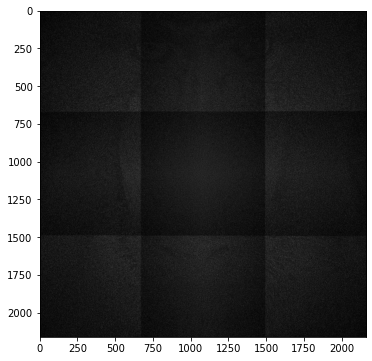

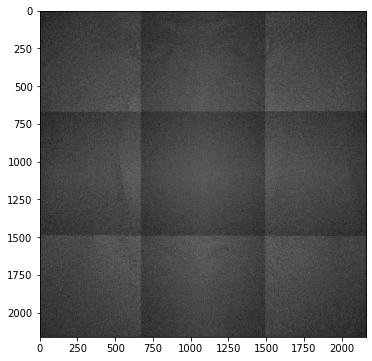

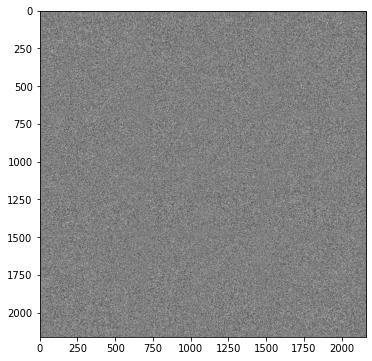

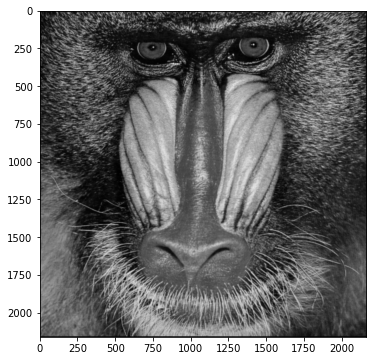

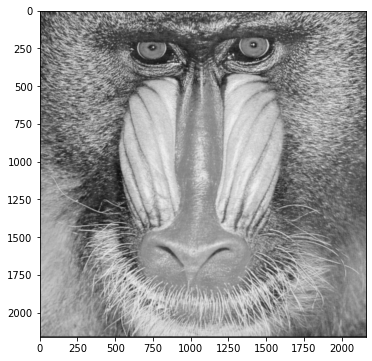

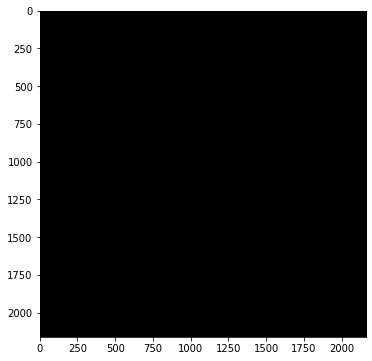

PSNR:  7.176328381927915
tf.Tensor(0.09579374810245957, shape=(), dtype=float64)


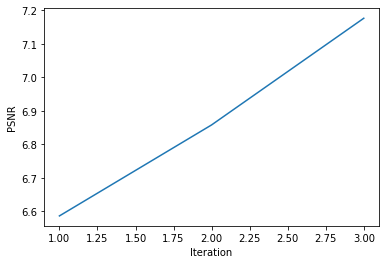

3
PSNR:  7.348699037423348
tf.Tensor(0.09206617507506668, shape=(), dtype=float64)
4


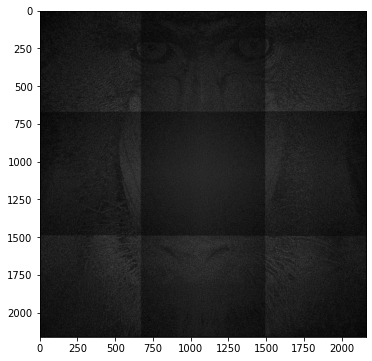

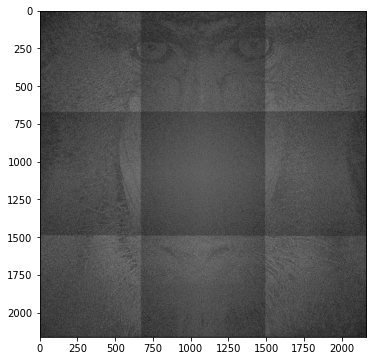

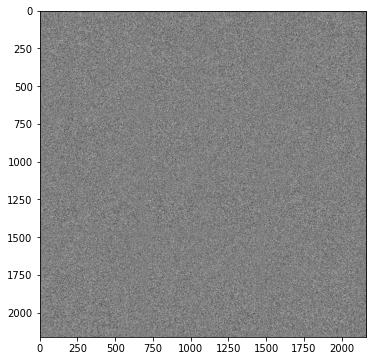

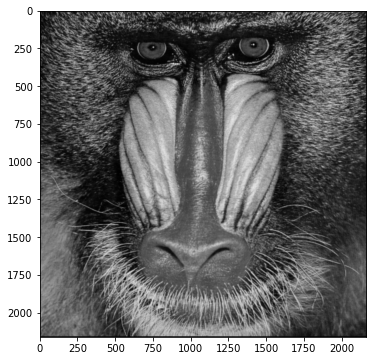

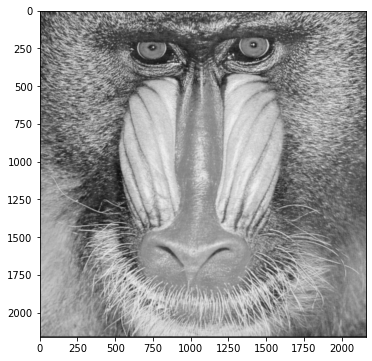

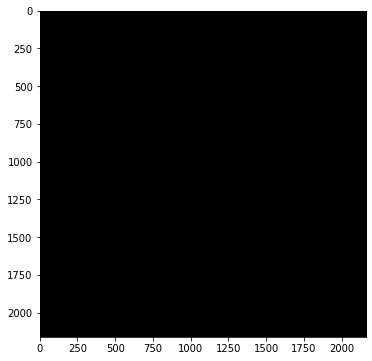

PSNR:  7.572867921892101
tf.Tensor(0.08743457676669879, shape=(), dtype=float64)


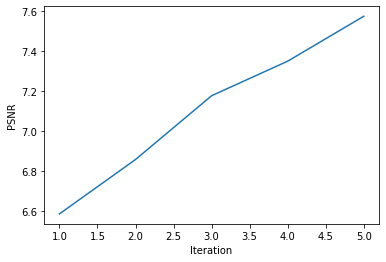

5
PSNR:  7.590734301127342
tf.Tensor(0.08707561975893065, shape=(), dtype=float64)
6


KeyboardInterrupt: 

: 

In [6]:
# opt = tf.keras.optimizers.Adam(learning_rate=1.0)
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

list_PSNR =[]
list_iter =[]

def loss_func():
    # phase: なんでもあり(定義域がない)の値, phase_exp: 複素振幅の形に, np.exp(phase)
    phase_exp = tf.dtypes.complex(tf.math.cos(phase), tf.math.sin(phase))
    

    # Input Complex Amplitude: SLMに光があたった状態（light_img: amplitude, A exp(iφ), exp(iφ): phase_exp）
    init_plane = tf.math.multiply(light_img, phase_exp)

    # Propagation from SLM to Image Plane with normalization
    init_plane_add = tf_CGH.add_zero_padding(init_plane)
    N = init_plane_add.shape[0]
    prop = tf_CGH.band_limited_angular_spectrum(init_plane_add, k, N, l_ambda, z, p)
#     prop = tf_CGH.angular_spectrum(init_plane_add, k, N, l_ambda, z, p)
#     prop = tf_CGH.normalize_amp_one(prop)
    prop_rm = tf_CGH.remove_zero_padding(prop)
    N = prop_rm.shape[0]

    '''
    # 1. prop_rmをレンズで変換します

    # 2. レンズで変換した直後の面から，再度伝播します

    # 3. 伝播結果を比較します
    '''

    ### 収差あり(P_xy:一般化瞳関数)/なし(p_xy: 瞳関数)レンズ変換
    u_minus = prop_rm
    u_minus = tf_CGH.add_zero_padding(prop_rm)
    lens = tf_CGH.response_h(2*N, l_ambda, -1.0*lens_f, p)
    u_plus = u_minus * lens * P_xy
    #u_plus = u_minus * lens * p_xy
    u_plus = tf_CGH.remove_zero_padding(u_plus)
    ###レンズからimageplaneまで伝搬計算
    u_plus_add = tf_CGH.add_zero_padding(u_plus)
    N = init_plane_add.shape[0]
    image_plane = tf_CGH.band_limited_angular_spectrum(u_plus_add, k, N, l_ambda, z, p)
    image_plane_rm = tf_CGH.remove_zero_padding(image_plane)
    N = image_plane_rm.shape[0]

    ### Show Images(強度、振幅、位相)
    
    if i % (loop//10) == 0 or i == loop-1:
        imgs = [
            CGH.amp_abs(CGH.intensity(image_plane_rm.numpy())),
            CGH.amp_abs(CGH.amplitude(image_plane_rm.numpy())),
            CGH.phase_norm(CGH.phase(image_plane_rm.numpy())),

            CGH.amp_abs(CGH.intensity(goal_img_tf.numpy())),
            CGH.amp_abs(CGH.amplitude(goal_img_tf.numpy())),
            CGH.phase_norm(CGH.phase(goal_img_tf.numpy())),
        ]
        ImageProcess.show_imgs(imgs)
    
    # Calculate Loss
    prop_inten = image_plane_rm * tf.math.conj(image_plane_rm)
    prop_inten = tf.dtypes.cast(prop_inten, tf.float64)
    prop_inten_norm = tf_CGH.normalize_amp_one(prop_inten)

    # PSNR value
    psnr_val = cv2.PSNR(prop_inten_norm.numpy(), target.numpy(), R=1)
    list_PSNR.append(psnr_val)
    print('PSNR: ', psnr_val)

    # target: これもintensity, それを二乗誤差で扱う
    err = prop_inten_norm - target
    loss = 1/2 * ( err ** 2 )
    print(tf.reduce_mean(loss))
    
    return loss

loop = 20
for i in range(loop):
    step_count = opt.minimize(loss_func, [phase]).numpy()
    list_iter.append(step_count)
    if i % (loop//10) == 0 or i == loop-1:
        plt.plot(list_iter, list_PSNR)
        plt.xlabel('Iteration')
        plt.ylabel('PSNR')
        plt.show()
    print(step_count)

In [6]:
#save image
phase_exp = tf.dtypes.complex(tf.math.cos(phase), tf.math.sin(phase))
init_plane = tf.math.multiply(light_img, phase_exp)
phase_img = CGH.phase_norm(CGH.phase(init_plane.numpy()))
out_dir = '../output/'
phase_img.min()
cv2.imwrite(out_dir + 'baboon-300step_with_abe_phase.png', phase_img)

True

: 

PSNR:  6.4482473048896995


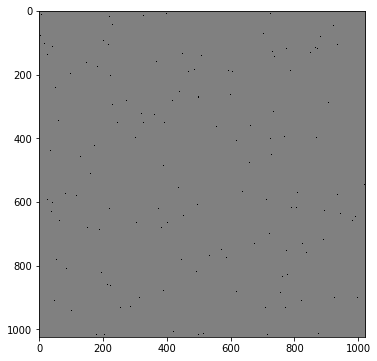

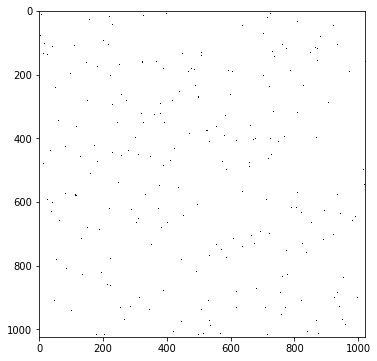

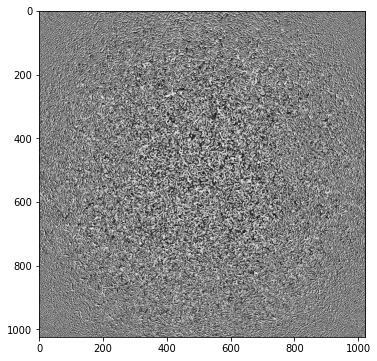

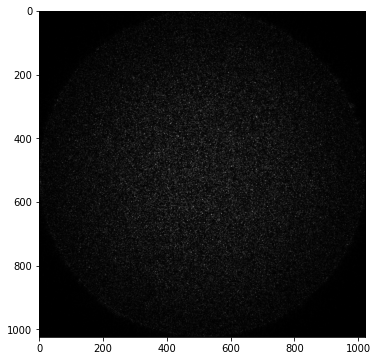

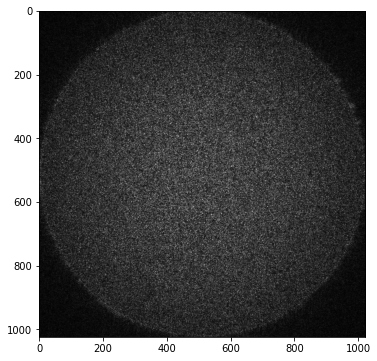

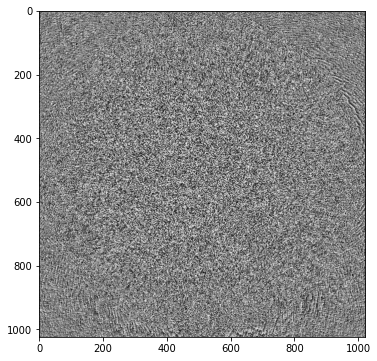

In [ ]:
##### Validate Optimization Result #####
# Input Image
phase_exp = tf.dtypes.complex(tf.math.cos(phase), tf.math.sin(phase))
input_plane = tf.math.multiply(light_img, phase_exp)
input_plane = input_plane.numpy()


# Propagation from SLM to Image Plane
input_plane_add = ImageProcess.add_zero_padding(input_plane)
N = input_plane_add.shape[0]
# recon_img = CGH.propagation(input_plane_add, N, l_ambda, z, p)
recon_img = CGH.band_limited_angular_spectrum(input_plane_add, N, l_ambda, z, p)
# recon_img = CGH.angular_spectrum(input_plane_add, N, l_ambda, z, p)
recon_img = ImageProcess.remove_zero_padding(recon_img)
N = recon_img.shape[0]


# PSNR value
recon_img_inten = ImageProcess.normalize_amp_one(CGH.intensity(recon_img))
psnr_val = cv2.PSNR(recon_img_inten, target.numpy(), R=1)
print('PSNR: ', psnr_val)


##### Check Images #####
imgs = [
        CGH.amp_abs(CGH.intensity(input_plane)),
        CGH.amp_abs(CGH.amplitude(input_plane)),
        CGH.phase_norm(CGH.phase(input_plane)),

        CGH.amp_abs(CGH.intensity(recon_img)),
        CGH.amp_abs(CGH.amplitude(recon_img)),
        CGH.phase_norm(CGH.phase(recon_img))

    ]
ImageProcess.show_imgs(imgs)
opt_out_path = out_path + 'opt_'
ImageProcess.save_imgs(opt_out_path, imgs)

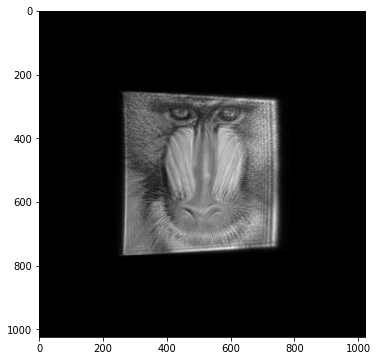

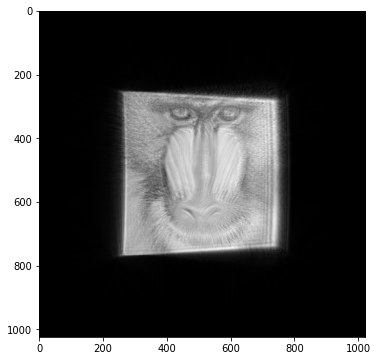

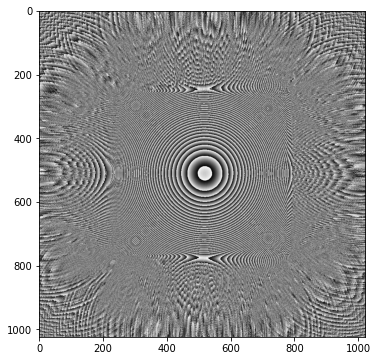

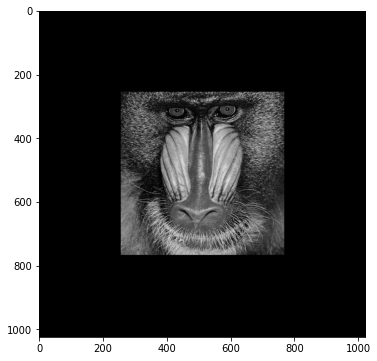

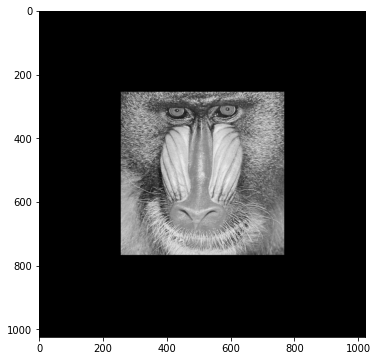

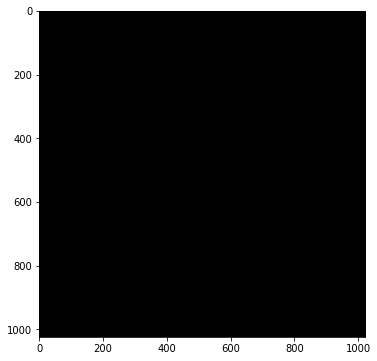

20.10092663476673


In [ ]:
# phase: なんでもあり(定義域がない)の値, phase_exp: 複素振幅の形に, np.exp(phase)
phase = np.zeros(size)
phase = tf.constant(phase)

phase_exp = tf.dtypes.complex(tf.math.cos(phase), tf.math.sin(phase))


# Input Complex Amplitude: source_img: amplitude, A exp(iφ), exp(iφ): phase_exp）
init_plane = tf.math.multiply(source_img, phase_exp)

# Propagation from SLM to Image Plane with normalization
init_plane_add = tf_CGH.add_zero_padding(init_plane)
N = init_plane_add.shape[0]
prop = tf_CGH.band_limited_angular_spectrum(init_plane_add, k, N, l_ambda, z, p)
prop_rm = tf_CGH.remove_zero_padding(prop)
N = prop_rm.shape[0]

'''
# 1. prop_rmをレンズで変換します

# 2. レンズで変換した直後の面から，再度伝播します

# 3. 伝播結果を比較します


'''
### 収差なしレンズ変換
u_minus = prop_rm
lens = CGH.response(N, l_ambda, -1.0*lens_f, p)
u_plus = u_minus * lens * P_xy


###レンズからimageplaneまで伝搬計算
u_plus_add = tf_CGH.add_zero_padding(u_plus)
N = init_plane_add.shape[0]
image_plane = tf_CGH.band_limited_angular_spectrum(u_plus_add, k, N, l_ambda, z, p)
image_plane_rm = tf_CGH.remove_zero_padding(image_plane)
N = image_plane_rm.shape[0]

### Show Images(強度、振幅、位相)

imgs = [
    CGH.amp_abs(CGH.intensity(image_plane_rm.numpy())),
    CGH.amp_abs(CGH.amplitude(image_plane_rm.numpy())),
    CGH.phase_norm(CGH.phase(image_plane_rm.numpy())),

    CGH.amp_abs(CGH.intensity(goal_img_tf.numpy())),
    CGH.amp_abs(CGH.amplitude(goal_img_tf.numpy())),
    CGH.phase_norm(CGH.phase(goal_img_tf.numpy())),
]
for i in range(3):
  imgs[i] = cv2.flip(imgs[i], -1) 
ImageProcess.show_imgs(imgs)

out_dir = 'drive/My Drive/Colab Notebooks/output/'

#cv2.imwrite(out_dir+'target.png', imgs[0])
print(cv2.PSNR(amp_img_np, imgs[0]/imgs[0].max(), R=1))




